### Pearson’s correlation

We check the absolute value of the Pearson’s correlation between the target and numerical features in our dataset. We keep the top n features based on this criterion

In [ ]:
def cor_selector(X, y,num_feats):
    cor_list = []
    feature_name = X.columns.tolist()
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-num_feats:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature
cor_support, cor_feature = cor_selector(X, y,num_feats)
print(str(len(cor_feature)), 'selected features')

### Chi-Squared 

In this method, we calculate the chi-square metric between the target and the numerical variable and only select the variable with the maximum chi-squared values.

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
X_norm = MinMaxScaler().fit_transform(X)
chi_selector = SelectKBest(chi2, k=num_feats)
chi_selector.fit(X_norm, y)
chi_support = chi_selector.get_support()
chi_feature = X.loc[:,chi_support].columns.tolist()
print(str(len(chi_feature)), 'selected features')

### Recursive Feature Elimination

The goal of recursive feature elimination (RFE) is to select features by recursively considering smaller and smaller sets of features. First, the estimator is trained on the initial set of features and the importance of each feature is obtained either through a coef_ attribute or through a feature_importances_ attribute. Then, the least important features are pruned from current set of features. That procedure is recursively repeated on the pruned set until the desired number of features to select is eventually reached.

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
rfe_selector = RFE(estimator=LogisticRegression(), n_features_to_select=num_feats, step=10, verbose=5)
rfe_selector.fit(X_norm, y)
rfe_support = rfe_selector.get_support()
rfe_feature = X.loc[:,rfe_support].columns.tolist()
print(str(len(rfe_feature)), 'selected features')

### Lasso: SelectFromModel

In [ ]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression

embeded_lr_selector = SelectFromModel(LogisticRegression(penalty="l1"), max_features=num_feats)
embeded_lr_selector.fit(X_norm, y)

embeded_lr_support = embeded_lr_selector.get_support()
embeded_lr_feature = X.loc[:,embeded_lr_support].columns.tolist()
print(str(len(embeded_lr_feature)), 'selected features')

### Tree-based: SelectFromModel

We calculate feature importance using node impurities in each decision tree. In Random forest, the final feature importance is the average of all decision tree feature importance.

In [ ]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100), max_features=num_feats)
embeded_rf_selector.fit(X, y)

embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()
print(str(len(embeded_rf_feature)), 'selected features')

We could also have used a LightGBM. Or an XGBoost object as long it has a feature_importances_ attribute.

In [ ]:
from sklearn.feature_selection import SelectFromModel
from lightgbm import LGBMClassifier

lgbc=LGBMClassifier(n_estimators=500, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2,
            reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)

embeded_lgb_selector = SelectFromModel(lgbc, max_features=num_feats)
embeded_lgb_selector.fit(X, y)

embeded_lgb_support = embeded_lgb_selector.get_support()
embeded_lgb_feature = X.loc[:,embeded_lgb_support].columns.tolist()
print(str(len(embeded_lgb_feature)), 'selected features')

### Ensemble approach 

In [ ]:
# put all selection together
feature_selection_df = pd.DataFrame({'Feature':feature_name, 'Pearson':cor_support, 'Chi-2':chi_support, 'RFE':rfe_support, 'Logistics':embeded_lr_support,
                                    'Random Forest':embeded_rf_support, 'LightGBM':embeded_lgb_support})
# count the selected times for each feature
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
# display the top 100
feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)
feature_selection_df.head(num_feats)


### Weight of Evidence (WOE) and Information Value (IV)

It is a very simple technique where an IDV is split into various bins and percentage contribution of both the classes of target variable is calculated. Then we calculate WOE and IV for each bin. Bins with similar IVs are clubbed together. For continuous variables the data is split into various bins depending on the distribution. You can also specify the number of bins that are to be created. Make sure that bins are created in such a manner that each has enough number of data points. But for categorical variables there is no such need of splitting, they are already in the desired format.

In [3]:
import pandas as pd
import numpy as np
import os as os
import math as math
from sklearn.feature_selection import SelectKBest, chi2

In [4]:
df = pd.read_csv('train.csv')

In [5]:
# No of rows and columns in a dataset
df.shape

(614, 13)

In [6]:
# Percentage of Null values in a dataset
(df.isnull().sum()) *100/ len(df)

Loan_ID              0.000000
Gender               2.117264
Married              0.488599
Dependents           2.442997
Education            0.000000
Self_Employed        5.211726
ApplicantIncome      0.000000
CoapplicantIncome    0.000000
LoanAmount           3.583062
Loan_Amount_Term     2.280130
Credit_History       8.143322
Property_Area        0.000000
Loan_Status          0.000000
dtype: float64

In [7]:
# Checking event rate
df['Loan_Status'].value_counts() * 100/len(df)

Y    68.729642
N    31.270358
Name: Loan_Status, dtype: float64

In [8]:
df_IV = df[['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'ApplicantIncome', 'LoanAmount', 
            'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status']]

In [9]:
# Converting variables like 'Dependent', 'Credit_History' and 'Loan_Amount_Term' to categorical variable
df_IV['Dependents'] = df_IV['Dependents'].astype(str)
df_IV['Credit_History'] = df_IV['Credit_History'].astype(str)
df_IV['Loan_Amount_Term'] = df_IV['Loan_Amount_Term'].astype(str)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

In [10]:
x = {}
y = {}
z = {}
for i in df_IV.columns:
    if(df_IV[i].dtype != 'object'):
        df_IV[i+'_decile'] = pd.qcut(df_IV[i], 10, labels=False)
        df_IV[i+'_decile'] = df_IV[i+'_decile'].fillna(-1)
        df_IV[i] = df_IV[i].fillna(-99)
        df_IV = pd.merge(pd.merge(df_IV, pd.DataFrame(data = df_IV[i].groupby(df_IV[i+'_decile']).max()).reset_index(), on = i+'_decile', how = 'left'),  pd.DataFrame(data = df_IV[i].groupby(df_IV[i+'_decile']).min()).reset_index(), on = i+'_decile', how = 'left') 
        z[i] = pd.DataFrame(pd.crosstab(df_IV[i+'_decile'].fillna('NA'), df_IV['Loan_Status'])).reset_index()
        z[i]['CR'] = z[i]['Y'] * 100/ z[i]['Y'].sum()
        z[i]['NCR'] = z[i]['N'] * 100/ z[i]['N'].sum()
        z[i]['WOR'] = np.log(z[i]['NCR']/ z[i]['CR'])
        z[i]['IV'] = (z[i]['WOR']/100) * (z[i]['NCR'] - z[i]['CR'])
        y[i] = z[i]['IV'].replace([np.inf, -np.inf], 0).sum()
    else:
        if(i!= 'Loan_Status'):
            x[i] = pd.DataFrame(pd.crosstab(df_IV[i].fillna('NA'), df_IV['Loan_Status'])).reset_index()
            x[i]['CR'] = (x[i]['Y']) * 100/ (x[i]['Y']).sum()
            x[i]['NCR'] = (x[i]['N']) * 100/ (x[i]['N']).sum()
            x[i]['WOE'] = np.log((x[i]['NCR'])/ (x[i]['CR']))
            x[i]['IV'] = (x[i]['WOE']/100) * (x[i]['NCR'] - x[i]['CR'])
            y[i] = x[i]['IV'].replace([np.inf, -np.inf], 0).sum()
t = pd.DataFrame(list(y.items()), columns = ['Variable', 'IV'])
t.sort_values(by = ['IV'], ascending = False)

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A valu

,Variable,IV
8,Credit_History,1.562226
9,Property_Area,0.096228
6,LoanAmount,0.066808
7,Loan_Amount_Term,0.053261
1,Married,0.036282
3,Education,0.033044
5,ApplicantIncome,0.030574
2,Dependents,0.028513
0,Gender,0.004077
4,Self_Employed,0.001234


In [11]:
x['Credit_History']

Loan_Status,Credit_History,N,Y,CR,NCR,WOE,IV
0,0.0,82,7,1.658768,42.708333,3.248319,1.333421
1,1.0,97,378,89.573460,50.520833,-0.572673,0.223644
2,nan,13,37,8.767773,6.770833,-0.258459,0.005161


### Correlation

In [12]:
df_corr = df
df_corr['target'] = np.where(df_corr['Loan_Status'] == 'Y', 1,0)
df_corr.corr()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,target
ApplicantIncome,1.000000,-0.116605,0.570909,-0.045306,-0.014715,-0.004710
CoapplicantIncome,-0.116605,1.000000,0.188619,-0.059878,-0.002056,-0.059187
LoanAmount,0.570909,0.188619,1.000000,0.039447,-0.008433,-0.037318
Loan_Amount_Term,-0.045306,-0.059878,0.039447,1.000000,0.001470,-0.021268
Credit_History,-0.014715,-0.002056,-0.008433,0.001470,1.000000,0.561678
target,-0.004710,-0.059187,-0.037318,-0.021268,0.561678,1.000000


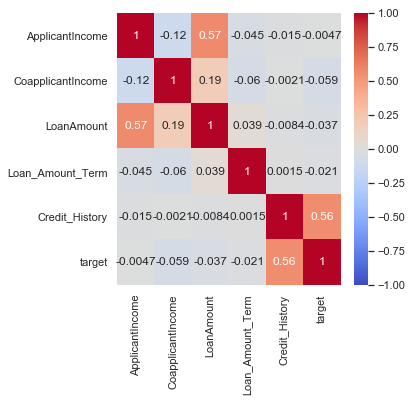

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
plt.figure(figsize=(5,5))
sns.heatmap(df_corr.corr(), vmin=-1, cmap='coolwarm', annot=True);

### SelectKBest

SelectKBest is a Python library which helps in identifying top K best features that can be used in building a model. SelectKBest can take different functions to identify top features.

In [14]:
X = df[['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area', 'Credit_History']]

In [15]:
X['Credit_History'] = X['Credit_History'].astype(str)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [16]:
X1 = pd.get_dummies(X, prefix = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area', 'Credit_History'], columns = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area', 'Credit_History'], 
               prefix_sep = '_', drop_first = 'True')

In [17]:
Y = df['Loan_Status']

In [18]:
bestfeatures = SelectKBest(score_func=chi2)
fit = bestfeatures.fit(X1,Y)
dfscores = pd.DataFrame(fit.scores_, columns = ['Score'])
dfcolumns = pd.DataFrame(X1.columns, columns = ['Variable'])

In [19]:
Imp = pd.merge(dfcolumns, dfscores, how = 'inner', left_index=True, right_index=True)
Imp.sort_values('Score', ascending = False).iloc[0:5]

,Variable,Score
9,Credit_History_1.0,26.014804
7,Property_Area_Semiurban,7.103093
5,Education_Not Graduate,3.540502
3,Dependents_2,1.996446
1,Married_Yes,1.534292
